In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import itertools

%pylab inline

# Data: GSS happiness vs. trust in people
In this example we are going to look at another pair of questions from General Social Survey conducted in 2018. 

Question 1: Taken all together, how would you say things are these days – would you say that you are very happy, pretty happy, or not too happy?

Question 2: Generally speaking, would you say that most people can be trusted or that you can't be too careful in dealing with people?

Are answers to these questions independent?

In [2]:
gss_data = pd.read_csv('happiness_trust.csv')
gss_data.head()

,happiness,trust
0,Very happy,Can trust
1,Very happy,Can't be too careful
2,Very happy,Can trust
3,Pretty happy,Can trust
4,Pretty happy,Can't be too careful


In [3]:
ct = pd.crosstab(gss_data.happiness, gss_data.trust)
ct

trust,Can trust,Can't be too careful,Depends
happiness,,,
Not too happy,43,197,9
Pretty happy,270,535,40
Very happy,179,260,19


# Chi squared test for independence
$H_0$: happiness and trust in people are independent

$H_1$: $H_0$ is false

In [4]:
stats.chi2_contingency(ct)

(37.58945272647462,
 1.3617693470270765e-07,
 4,
 array([[ 78.93556701, 159.15463918,  10.90979381],
        [267.87371134, 540.10309278,  37.02319588],
        [145.19072165, 292.74226804,  20.06701031]]))

$p=1.4\times10^{-7}<0.05$ – null hypothesis is rejected. None of the expected counts (the array returned above) are below 5, so chi-squared test is accurate.

# Permutation test for independence

Chi squared test is perfectly fine for this dataset since the expected counts are quite high (so the approximation is valid), but let's apply permutation test anyway – so you'll have an example of it.

In [5]:
def permutation_stat_cat_ind(sample1, sample2):
    ct = pd.crosstab(sample1, sample2)
    return stats.chi2_contingency(ct)[0]

def get_random_permutations(n, max_permutations):
    index = np.array(range(n))
    indices = set([tuple(index)])        
    for i in range(max_permutations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return list(indices)

def permutation_null_dist_cat_ind(sample1, sample2, max_permutations = None):
    if not len(sample1) == len(sample2):
        raise ValueError("Samples should be paired and have the same size")
        
    n = len(sample1)
    
    if max_permutations:
        indices = get_random_permutations(n, max_permutations)
    else:
        indices = list(itertools.permutations(list(range(n))))
    
    distr = [permutation_stat_cat_ind(sample1, sample2[list(i)]) for i in indices]
    return distr

def permutation_test_cat_ind(sample1, sample2, max_permutations = None, return_distr = False):    
    t_stat = permutation_stat_cat_ind(sample1, sample2)
    
    null_distr = permutation_null_dist_cat_ind(sample1, sample2, max_permutations)
    
    p = sum([1. if x >= t_stat else 0. for x in null_distr]) / len(null_distr)
        
    if return_distr:
        return {'t': t_stat, 'p': p, 'null_distr': null_distr}
    else:
        return {'t': t_stat, 'p': p}

In [6]:
res= permutation_test_cat_ind(gss_data.happiness.values, gss_data.trust.values, 
                              max_permutations = 10000, return_distr = True)
print("Permutation test: t = %f, p = %f" % (res['t'], res['p']))

Permutation test: t = 37.589453, p = 0.000100


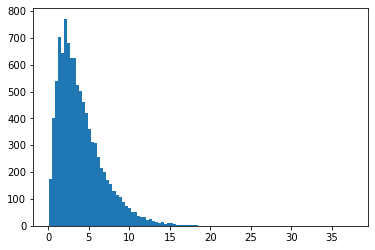

In [7]:
pylab.hist(res['null_distr'], bins = 100);

# Follow-up: standardized Pearson residuals

In [8]:
def st_pearson_residuals(ct):
    e = stats.chi2_contingency(ct)[3]
    r = e
    n_plus_j = sum(ct, axis=0)
    n_i_plus = sum(ct, axis=1)
    n = sum(n_plus_j)
    for i in range(len(n_i_plus)):
        for j in range(len(n_plus_j)):
            r[i,j] = (ct.values[i,j] - e[i,j]) / np.sqrt(e[i,j] * (1 - n_i_plus[i] / n) * (1 - n_plus_j[j] / n))
    return pd.DataFrame(data=r, index = ct.index, columns = ct.columns)
    

In [9]:
st_pearson_residuals(ct)

trust,Can trust,Can't be too careful,Depends
happiness,,,
Not too happy,-5.341395,5.450401,-0.645328
Pretty happy,0.232909,-0.541606,0.741273
Very happy,4.043864,-3.794505,-0.290130


Looks like unhappy people trust people less, and happy people trust people more than it would have been if these two variables were independent!